# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate media unit $u$;
* $units(i):$ all input media units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on media unit $u$ as a binary vector;
* $MediaUnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input media unit.

## Media Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input media unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the media unit. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the annotation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across media units. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-media unit agreement $WUA(i)$.

$$ WQS(i) = WUA(i) \; WWA(i) .$$

### Worker-Media Unit Agreement

The worker-media unit agreement $WUA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the media units they have worked on, weighted by the media unit and annotation quality. It calculates how much a worker disagrees with the crowd on a media unit basis. Through the weighted average, media units and anntation with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{u \in units(i)} Wcos(WorkVec(i,u), MediaUnitVec(u) - WorkVec(i, u)) \; UQS(u)}{\sum_{u \in units(i)} UQS(u)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same media units as worker $i$, weighted by the worker and annotation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(u \in units(i))} Wcos(WorkVec(i, u), WorkVec(j, u)) \; WQS(j) \; UQS(u) }{ \sum_{j \in workers(s \in units(i))} WQS(j) \; UQS(u) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting an annotation $a$, over all the media units it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input media units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a media unit, worker $i$ will also annotate it. 

$$ P_a(i | j) = \frac{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(j, u)(r) } . $$

$AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input media units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j . $$


## Media Unit-Annotation Score (UAS)

The media unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input media unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(u)} WorkVec(i,u)(a) \; WQS(i) }{ \sum_{i \in workers(u)} WQS(i) }. $$

# How to run the metrics


In [1]:
# Read data
import pandas as pd

pd.set_option('display.max_columns', None)
passages_per_article_random_filename = "AnalysisFiles/2P_WithHighlight_Passages_Random/2p_withHighlight_15workers_passages.csv"
passages_per_article_random_dataset = pd.read_csv(passages_per_article_random_filename)

passages_per_article_random_dataset.head(10)

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,hiddeninput,highlighted1,highlighted10,highlighted11,highlighted12,highlighted13,highlighted14,highlighted15,highlighted16,highlighted17,highlighted18,highlighted19,highlighted2,highlighted20,highlighted3,highlighted4,highlighted5,highlighted6,highlighted7,highlighted8,highlighted9,notrelevant_snippets,relevance_s1,relevance_s2,relevance_s3,relevance_s4,relevance_s5,relevant_snippets,startchars1,startchars10,startchars11,startchars12,startchars13,startchars14,startchars15,startchars16,startchars17,startchars18,startchars19,startchars2,startchars20,startchars3,startchars4,startchars5,startchars6,startchars7,startchars8,startchars9,termnumber1,termnumber10,termnumber11,termnumber12,termnumber13,termnumber14,termnumber15,termnumber16,termnumber17,termnumber18,termnumber19,termnumber2,termnumber20,termnumber3,termnumber4,termnumber5,termnumber6,termnumber7,termnumber8,termnumber9,bin,doc_len,document_body,document_id,document_title,hiddeninput_gold,highlighted10_gold,highlighted11_gold,highlighted12_gold,highlighted13_gold,highlighted14_gold,highlighted15_gold,highlighted16_gold,highlighted17_gold,highlighted18_gold,highlighted19_gold,highlighted1_gold,highlighted20_gold,highlighted2_gold,highlighted3_gold,highlighted4_gold,highlighted5_gold,highlighted6_gold,highlighted7_gold,highlighted8_gold,highlighted9_gold,index,notrelevant_snippets_gold,rel,relevance_s1_gold,relevance_s2_gold,relevance_s3_gold,relevance_s4_gold,relevance_s5_gold,relevant_snippets_gold,sentence0,sentence1,sentence10,sentence11,sentence12,sentence13,sentence14,sentence15,sentence16,sentence17,sentence18,sentence19,sentence2,sentence20,sentence3,sentence4,sentence5,sentence6,sentence7,sentence8,sentence9,startchars10_gold,startchars11_gold,startchars12_gold,startchars13_gold,startchars14_gold,startchars15_gold,startchars16_gold,startchars17_gold,startchars18_gold,startchars19_gold,startchars1_gold,startchars20_gold,startchars2_gold,startchars3_gold,startchars4_gold,startchars5_gold,startchars6_gold,startchars7_gold,startchars8_gold,startchars9_gold,termnumber10_gold,termnumber11_gold,termnumber12_gold,termnumber13_gold,termnumber14_gold,termnumber15_gold,termnumber16_gold,termnumber17_gold,termnumber18_gold,termnumber19_gold,termnumber1_gold,termnumber20_gold,termnumber2_gold,termnumber3_gold,termnumber4_gold,termnumber5_gold,termnumber6_gold,termnumber7_gold,termnumber8_gold,termnumber9_gold,topic,topic_description,topic_query
0,1431564978,10/31/2017 22:32:49,2975564591,10/31/2017 22:31:50,False,instagc,1,19302668,USA,IN,Avon,107.147.110.170,NaN,"[""religious"",""group"",""killed"",""12"",""people""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""sect's"",""property""]",NaN,"[""Aleph"",""Aum"",""Shinrikyo"",""sect""]","[""group's""]","[""violation"",""group's"",""basic"",""rights""]",NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,"s1,s2,s4,s5,s3","[""92 "",""111 "",""143 "",""162 "",""178 ""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""864 "",""907 ""]",NaN,"[""221 "",""265 "",""287 "",""364 ""]","[""205 ""]","[""129 "",""182 "",""204 "",""225 ""]",NaN,NaN,NaN,NaN,"[""9 "",""10 "",""12 "",""13 "",""14 ""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""36 "",""37 ""]",NaN,"[""16 "",""18 "",""19 "",""22 ""]","[""15 ""]","[""11 "",""14 "",""15 "",""16 ""]",NaN,NaN,NaN,NaN,1,196,<p>A public commission ruled today that Aum Sh...,1173003,Japan Puts Gas-Attack Sect Under Scrutiny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Japan Puts Gas-Attack Sect Under Scrutiny,A public commission ruled today that Aum Shinr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The Public Security Examination Commission, wh...",NaN,Under the surveillance law -- specifically dir...,"Beginning on Tuesday, when the commission's de...",Human rights advocates and civil libertarians ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

### Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [70]:
import sys
sys.path.append('../')

from defaultconfig import Configuration

class NYTRelevanceAssessmentValidationConfig(Configuration):
    inputColumns = ["index", "bin", "doc_len", "document_id", "document_body", "document_title", "rel", 
                    "topic", "topic_description", "topic_query"]
    outputColumns = ["relevant_snippets"]
    
    annotation_separator = ','
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = [
        "highly_relevant", "relevant", "not_relevant"
    ]
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: x.replace(' ',','))
        return judgments

config = NYTRelevanceAssessmentValidationConfig()

### Pre-process the data and create the annotation vectors


In [71]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [4]:
from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename,
    config=config
)

### Run the metrics

In [5]:
# run the metrics
from models import Metrics
results_passages_per_article_random = Metrics.run(pre_processed_results, config)

INFO:root:1 iterations; max d= 0.866736925645 ; wqs d= 0.705247454989; sqs d= 0.562036650731; rqs d= 0.0
INFO:root:2 iterations; max d= 0.17907366172 ; wqs d= 0.048072102429; sqs d= 0.0512420762828; rqs d= 0.0
INFO:root:3 iterations; max d= 0.0393995958932 ; wqs d= 0.0113896052434; sqs d= 0.0121327745765; rqs d= 0.0
INFO:root:4 iterations; max d= 0.0200443586039 ; wqs d= 0.00491651686252; sqs d= 0.00604465003679; rqs d= 0.0
INFO:root:5 iterations; max d= 0.0107189546247 ; wqs d= 0.0023658774584; sqs d= 0.00348384966479; rqs d= 0.0
INFO:root:6 iterations; max d= 0.00565417716925 ; wqs d= 0.00134562897759; sqs d= 0.00188479866493; rqs d= 0.0
INFO:root:7 iterations; max d= 0.00332611058419 ; wqs d= 0.00077201645089; sqs d= 0.00116874931524; rqs d= 0.0
INFO:root:8 iterations; max d= 0.00189305671689 ; wqs d= 0.000458576798644; sqs d= 0.000671495589357; rqs d= 0.0
INFO:root:9 iterations; max d= 0.00112406614931 ; wqs d= 0.000268908225123; sqs d= 0.000402106125907; rqs d= 0.0
INFO:root:10 it

In [6]:
results_passages_per_article_random["units"].head(5)

,duration,input.bin,input.doc_len,input.document_body,input.document_id,input.document_title,input.index,input.rel,input.topic,input.topic_description,input.topic_query,job,output.relevant_snippets,output.relevant_snippets.annotations,output.relevant_snippets.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,,,,
1431564978,93.733333,1,196,<p>A public commission ruled today that Aum Sh...,1173003,Japan Puts Gas-Attack Sect Under Scrutiny,1,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 6, u's3': 7, u's2': 5, u's1': 9, u's...",36,6,15,0.384890,"{u'none': 0.432018013226, u's3': 0.49447195659...",0.382460,"{u'none': 0.4, u's3': 0.466666666667, u's2': 0..."
1431564979,96.066667,1,245,<p>ABC has signed a deal to develop a televisi...,920343,ABC Signs Film Deal On the Cult,2,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 5, u's3': 3, u's2': 8, u's1': 7, u's...",34,6,15,0.391852,"{u'none': 0.370325944523, u's3': 0.09590969514...",0.358433,"{u'none': 0.333333333333, u's3': 0.2, u's2': 0..."
1431564980,106.866667,1,242,<p>Japan's peace of mind was shattered anew by...,757222,April 16-22; The Scent of Terror,3,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 6, u's3': 4, u's2': 5, u's1': 4, u's...",39,8,15,0.329565,"{u'none': 0.423790313297, u's3': 0.16629433868...",0.302674,"{u'none': 0.4, u's3': 0.266666666667, u's2': 0..."
1431564981,55.666667,1,237,"<p>USA Networks Interactive, creator of the sc...",1209320,SCIFI.com in Venture With Filmmaker,4,0,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 10, u's3': 2, u's1': 5, u's6': 4, u'...",23,6,15,0.584022,"{u'none': 0.757338980092, u's3': 0.06952752879...",0.491836,"{u'none': 0.666666666667, u's3': 0.13333333333..."
1431564982,51.800000,1,140,<p>To the Editor:</p> <p>There is ample eviden...,1667028,Vital at 50: Does Lifestyle Matter?,5,0,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 11, u's8': 1, u's3': 3, u's6': 3, u'...",23,6,15,0.752231,"{u'none': 0.87126939374, u's8': 0.034057054090...",0.562304,"{u'none': 0.733333333333, u's8': 0.06666666666..."


### Plot the unit quality score (UQS) at the beginning of the process and at the end

Text(0,0.5,u'# Units')

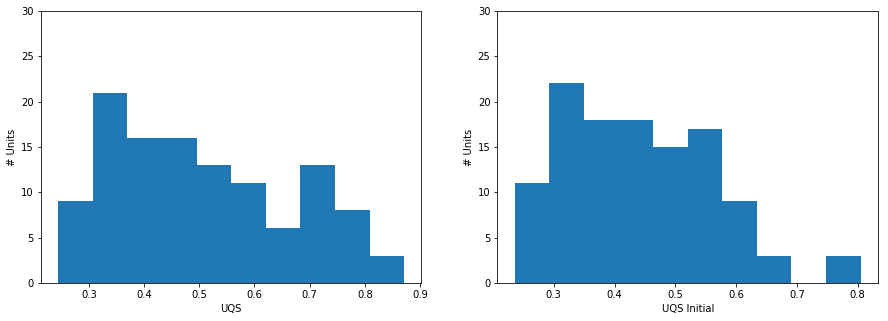

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results_passages_per_article_random["units"]["uqs"])
plt.ylim(0, 30)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(results_passages_per_article_random["units"]["uqs_initial"])
plt.ylim(0, 30)
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

### Plot the change in the unit quality score (UQS) (beginning of the process - end of the process)

Text(0,0.5,u'Change in clarity')

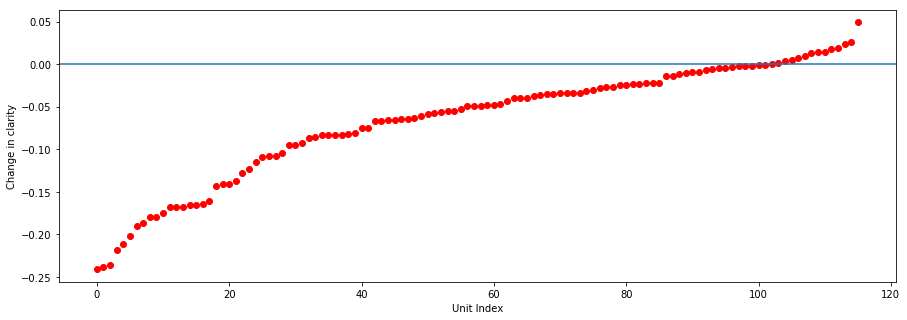

In [8]:
import numpy as np

difference = results_passages_per_article_random["units"]["uqs_initial"] - results_passages_per_article_random["units"]["uqs"]
difference = np.sort(difference)
plt.plot(np.arange(results_passages_per_article_random["units"].shape[0]), difference, 'ro')
plt.axhline(y=0)
plt.xlabel("Unit Index")
plt.ylabel("Change in clarity")

In [9]:
sortUQS = results_passages_per_article_random["units"].sort(['uqs'], ascending=[1])

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


Text(0.5,0,u'Sentence Index')

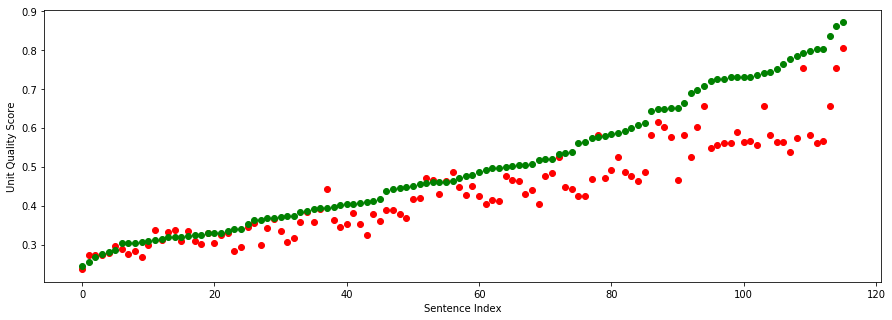

In [10]:
import numpy as np

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Sentence Index')

### Plot the worker quality score (WQS) at the beginning of the process and at the end

#### Print the results for the workers in our dataset

In [11]:
results_passages_per_article_random["workers"].head(10)

,duration,output.relevant_snippets.count,job,judgment,unit,wqs,wqs_initial
worker,,,,,,,
1855113,41.807692,1.076923,1,26,26,0.214517,0.155482
1924522,46.533333,1.666667,1,30,30,0.508313,0.360971
4316379,114.000000,1.290323,1,31,31,0.247562,0.205700
6336109,315.000000,2.000000,1,1,1,0.175129,0.153725
6367365,112.000000,3.000000,1,1,1,0.427813,0.411603
11131207,78.550000,1.210000,1,100,100,0.400879,0.293441
15004831,60.000000,1.000000,1,1,1,0.455473,0.394911
15965551,104.692308,1.230769,1,13,13,0.192877,0.133263
18386513,112.121212,1.727273,1,33,33,0.372438,0.284122


Text(0,0.5,u'# Workers')

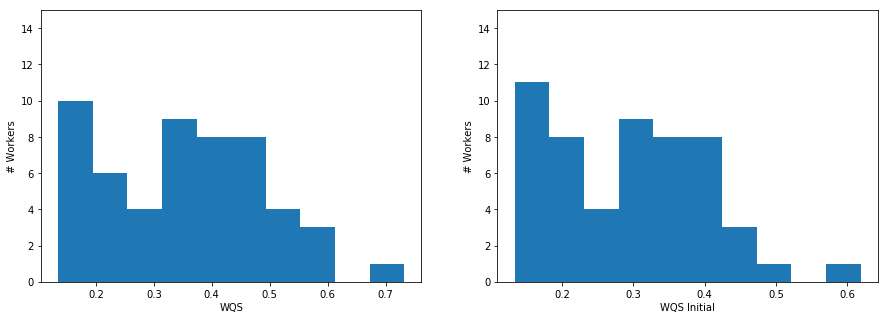

In [12]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results_passages_per_article_random["workers"]["wqs"])
plt.ylim(0, 15)
plt.xlabel("WQS")
plt.ylabel("# Workers")

plt.subplot(1, 2, 2)
plt.hist(results_passages_per_article_random["workers"]["wqs_initial"])
plt.ylim(0, 15)
plt.xlabel("WQS Initial")
plt.ylabel("# Workers")

### Plot the change in worker qualtity score at the beginning of the process and at the end

In [13]:
sortWQS = results_passages_per_article_random["workers"].sort(['wqs'], ascending=[1])

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


Text(0.5,0,u'Worker Index')

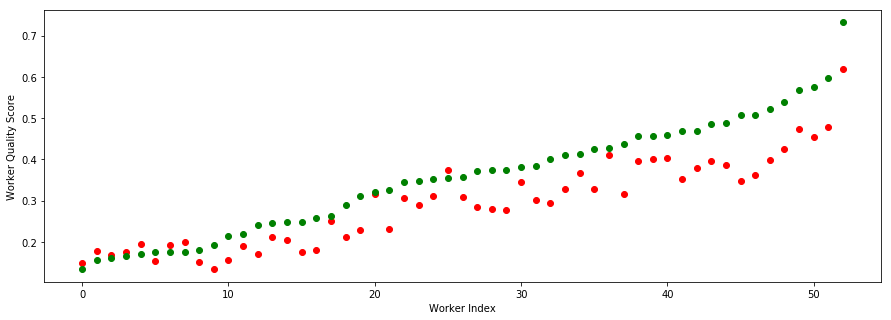

In [14]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Worker Quality Score')
plt.xlabel('Worker Index')
#plt.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size':12})

In [15]:
import numpy as np
import pandas as pd

results_passages_per_article_random["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random["units"])), index=results_passages_per_article_random["units"].index)
results_passages_per_article_random["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random["units"])), index=results_passages_per_article_random["units"].index)


In [16]:
for i in xrange(0, len(results_passages_per_article_random["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random["units"]['none_score'].iloc[i] = 0.0
        

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
gt = pd.read_csv("ground_truth_annotation.csv")

results_passages_per_article_random["units"]["reviewers_rel"] = pd.Series(np.random.randn(len(results_passages_per_article_random["units"].index)), index=results_passages_per_article_random["units"].index)
results_passages_per_article_random["units"]["reviewers_rel_merged"] = pd.Series(np.random.randn(len(results_passages_per_article_random["units"].index)), index=results_passages_per_article_random["units"].index)
results_passages_per_article_random["units"]["rel_merged"] = pd.Series(np.random.randn(len(results_passages_per_article_random["units"].index)), index=results_passages_per_article_random["units"].index)

for i in range(0, len(results_passages_per_article_random["units"].index)):
    for j in range(0, len(gt.index)):
        if (results_passages_per_article_random["units"]["input.topic"].iloc[i] == gt["topic"].iloc[j]) and (results_passages_per_article_random["units"]["input.document_id"].iloc[i] == gt["document_id"].iloc[j]):
            results_passages_per_article_random["units"]["reviewers_rel"].iloc[i] = gt["reviewers_rel"].iloc[j]
            results_passages_per_article_random["units"]["reviewers_rel_merged"].iloc[i] = gt["reviewers_rel_merged"].iloc[j]
            results_passages_per_article_random["units"]["rel_merged"].iloc[i] = gt["nist_rel_merged"].iloc[j]

In [18]:
results_passages_per_article_random["units"]

,duration,input.bin,input.doc_len,input.document_body,input.document_id,input.document_title,input.index,input.rel,input.topic,input.topic_description,input.topic_query,job,output.relevant_snippets,output.relevant_snippets.annotations,output.relevant_snippets.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial,max_relevance_score,none_score,reviewers_rel,reviewers_rel_merged,rel_merged
unit,,,,,,,,,,,,,,,,,,,,,,,,,
1431564978,93.733333,1,196,<p>A public commission ruled today that Aum Sh...,1173003,Japan Puts Gas-Attack Sect Under Scrutiny,1,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 6, u's3': 7, u's2': 5, u's1': 9, u's...",36,6,15,0.384890,"{u'none': 0.432018013226, u's3': 0.49447195659...",0.382460,"{u'none': 0.4, u's3': 0.466666666667, u's2': 0...",0.567982,0.432018,1.0,1.0,1.0
1431564979,96.066667,1,245,<p>ABC has signed a deal to develop a televisi...,920343,ABC Signs Film Deal On the Cult,2,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 5, u's3': 3, u's2': 8, u's1': 7, u's...",34,6,15,0.391852,"{u'none': 0.370325944523, u's3': 0.09590969514...",0.358433,"{u'none': 0.333333333333, u's3': 0.2, u's2': 0...",0.569698,0.370326,1.0,1.0,1.0
1431564980,106.866667,1,242,<p>Japan's peace of mind was shattered anew by...,757222,April 16-22; The Scent of Terror,3,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 6, u's3': 4, u's2': 5, u's1': 4, u's...",39,8,15,0.329565,"{u'none': 0.423790313297, u's3': 0.16629433868...",0.302674,"{u'none': 0.4, u's3': 0.266666666667, u's2': 0...",0.474604,0.423790,1.0,1.0,1.0
1431564981,55.666667,1,237,"<p>USA Networks Interactive, creator of the sc...",1209320,SCIFI.com in Venture With Filmmaker,4,0,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 10, u's3': 2, u's1': 5, u's6': 4, u'...",23,6,15,0.584022,"{u'none': 0.757338980092, u's3': 0.06952752879...",0.491836,"{u'none': 0.666666666667, u's3': 0.13333333333...",0.242661,0.757339,0.0,0.0,0.0
1431564982,51.800000,1,140,<p>To the Editor:</p> <p>There is ample eviden...,1667028,Vital at 50: Does Lifestyle Matter?,5,0,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u'none': 11, u's8': 1, u's3': 3, u's6': 3, u'...",23,6,15,0.752231,"{u'none': 0.87126939374, u's8': 0.034057054090...",0.562304,"{u'none': 0.733333333333, u's8': 0.06666666666...",0.128731,0.871269,0.0,0.0,0.0
1431564983,41.133333,1,173,<p>To the Editor:</p> <p>An Oct. 6 news articl...,717639,Not a Rosicrucian,6,0,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u's3': 10, u's2': 6, u'none': 4, u's4': 7}",27,4,15,0.455611,"{u's3': 0.732795905943, u's2': 0.482949555145,...",0.419650,"{u's3': 0.666666666667, u's2': 0.4, u'none': 0...",0.732796,0.235126,1.0,1.0,0.0
1431564984,44.933333,1,153,<p>The body of a man was found yesterday float...,615531,Body Found Floating Off Queens Coastline,31,1,362,Identify incidents of human smuggling.,human smuggling,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u's3': 1, u's2': 10, u's1': 2, u'none': 4}",17,4,15,0.538229,"{u's3': 0.0354704747013, u's2': 0.738122029414...",0.443055,"{u's3': 0.0666666666667, u's2': 0.666666666667...",0.738122,0.229800,2.0,1.0,1.0
1431564985,37.600000,1,102,<p>A violent gang brought boatloads of Chinese...,750492,New Jersey Daily Briefing; 14 Indicted in Immi...,32,2,362,Identify incidents of human smuggling.,human smuggling,AnalysisFiles/2P_WithHighlight_Passages_Random...,"{u's3': 1, u's2': 10, u's1': 7, u'none': 5}",23,4,15,0.477919,"{u's3': 0.0768223146914, u's2': 0.702988944632...",0.451038,"{u's

In [19]:
results_passages_per_article_random["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages.csv", index=False)

# Evaluate the position of the paragraphs

In [48]:
# Read data
import pandas as pd

pd.set_option('display.max_columns', None)
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/2p_withHighlight_15workers_passages.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

passages_per_article_random_dataset_all.head(3)

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,hiddeninput,highlighted1,highlighted10,highlighted11,highlighted12,highlighted13,highlighted14,highlighted15,highlighted16,highlighted17,highlighted18,highlighted19,highlighted2,highlighted20,highlighted3,highlighted4,highlighted5,highlighted6,highlighted7,highlighted8,highlighted9,notrelevant_snippets,relevance_s1,relevance_s2,relevance_s3,relevance_s4,relevance_s5,relevant_snippets,startchars1,startchars10,startchars11,startchars12,startchars13,startchars14,startchars15,startchars16,startchars17,startchars18,startchars19,startchars2,startchars20,startchars3,startchars4,startchars5,startchars6,startchars7,startchars8,startchars9,termnumber1,termnumber10,termnumber11,termnumber12,termnumber13,termnumber14,termnumber15,termnumber16,termnumber17,termnumber18,termnumber19,termnumber2,termnumber20,termnumber3,termnumber4,termnumber5,termnumber6,termnumber7,termnumber8,termnumber9,bin,doc_len,document_body,document_id,document_title,hiddeninput_gold,highlighted10_gold,highlighted11_gold,highlighted12_gold,highlighted13_gold,highlighted14_gold,highlighted15_gold,highlighted16_gold,highlighted17_gold,highlighted18_gold,highlighted19_gold,highlighted1_gold,highlighted20_gold,highlighted2_gold,highlighted3_gold,highlighted4_gold,highlighted5_gold,highlighted6_gold,highlighted7_gold,highlighted8_gold,highlighted9_gold,index,notrelevant_snippets_gold,rel,relevance_s1_gold,relevance_s2_gold,relevance_s3_gold,relevance_s4_gold,relevance_s5_gold,relevant_snippets_gold,sentence0,sentence1,sentence10,sentence11,sentence12,sentence13,sentence14,sentence15,sentence16,sentence17,sentence18,sentence19,sentence2,sentence20,sentence3,sentence4,sentence5,sentence6,sentence7,sentence8,sentence9,startchars10_gold,startchars11_gold,startchars12_gold,startchars13_gold,startchars14_gold,startchars15_gold,startchars16_gold,startchars17_gold,startchars18_gold,startchars19_gold,startchars1_gold,startchars20_gold,startchars2_gold,startchars3_gold,startchars4_gold,startchars5_gold,startchars6_gold,startchars7_gold,startchars8_gold,startchars9_gold,termnumber10_gold,termnumber11_gold,termnumber12_gold,termnumber13_gold,termnumber14_gold,termnumber15_gold,termnumber16_gold,termnumber17_gold,termnumber18_gold,termnumber19_gold,termnumber1_gold,termnumber20_gold,termnumber2_gold,termnumber3_gold,termnumber4_gold,termnumber5_gold,termnumber6_gold,termnumber7_gold,termnumber8_gold,termnumber9_gold,topic,topic_description,topic_query
0,1431564978,10/31/2017 22:32:49,2975564591,10/31/2017 22:31:50,False,instagc,1,19302668,USA,IN,Avon,107.147.110.170,NaN,"[""religious"",""group"",""killed"",""12"",""people""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""sect's"",""property""]",NaN,"[""Aleph"",""Aum"",""Shinrikyo"",""sect""]","[""group's""]","[""violation"",""group's"",""basic"",""rights""]",NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,"s1,s2,s4,s5,s3","[""92 "",""111 "",""143 "",""162 "",""178 ""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""864 "",""907 ""]",NaN,"[""221 "",""265 "",""287 "",""364 ""]","[""205 ""]","[""129 "",""182 "",""204 "",""225 ""]",NaN,NaN,NaN,NaN,"[""9 "",""10 "",""12 "",""13 "",""14 ""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""36 "",""37 ""]",NaN,"[""16 "",""18 "",""19 "",""22 ""]","[""15 ""]","[""11 "",""14 "",""15 "",""16 ""]",NaN,NaN,NaN,NaN,1,196,<p>A public commission ruled today that Aum Sh...,1173003,Japan Puts Gas-Attack Sect Under Scrutiny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Japan Puts Gas-Attack Sect Under Scrutiny,A public commission ruled today that Aum Shinr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The Public Security Examination Commission, wh...",NaN,Under the surveillance law -- specifically dir...,"Beginning on Tuesday, when the commission's de...",Human rights advocates and civil libertarians ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [49]:
rows_19 = []
rows_19.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's20' in snippets:
        snippets.remove('s20')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = ','.join(snippets)
    rows_19.append(list(passages_per_article_random_dataset_all.iloc[i]))

import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max19.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_19)

In [50]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max19.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_18 = []
rows_18.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's19' in snippets:
        snippets.remove('s19')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets)
    rows_18.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max18.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_18)

In [51]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max18.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_17 = []
rows_17.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's18' in snippets:
        snippets.remove('s18')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_17.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max17.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_17)

In [52]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max17.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_16 = []
rows_16.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's17' in snippets:
        snippets.remove('s17')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_16.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max16.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_16)

In [53]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max16.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_15 = []
rows_15.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's16' in snippets:
        snippets.remove('s16')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = ','.join(snippets)
    rows_15.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max15.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_15)

In [54]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max15.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_14 = []
rows_14.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's15' in snippets:
        snippets.remove('s15')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = ','.join(snippets)
    rows_14.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max14.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_14)

In [55]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max14.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_13 = []
rows_13.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's14' in snippets:
        snippets.remove('s14')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_13.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max13.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_13)

In [56]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max13.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_12 = []
rows_12.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's13' in snippets:
        snippets.remove('s13')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_12.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max12.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_12)

In [57]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max12.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_11 = []
rows_11.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's12' in snippets:
        snippets.remove('s12')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_11.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max11.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_11)

In [58]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max11.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_10 = []
rows_10.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's11' in snippets:
        snippets.remove('s11')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = ','.join(snippets)
    rows_10.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max10.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_10)

In [59]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max10.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_9 = []
rows_9.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's10' in snippets:
        snippets.remove('s10')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = ','.join(snippets)
    rows_9.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max9.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_9)

In [60]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max9.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_8 = []
rows_8.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's9' in snippets:
        snippets.remove('s9')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = ','.join(snippets)
    rows_8.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max8.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_8)

In [61]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max8.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_7 = []
rows_7.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's8' in snippets:
        snippets.remove('s8')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = ','.join(snippets)
    rows_7.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max7.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_7)

In [62]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max7.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_6 = []
rows_6.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's7' in snippets:
        snippets.remove('s7')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_6.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max6.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_6)

In [63]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max6.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_5 = []
rows_5.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's6' in snippets:
        snippets.remove('s6')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_5.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max5.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_5)

In [64]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max5.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_4 = []
rows_4.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's5' in snippets:
        snippets.remove('s5')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets)
    rows_4.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max4.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_4)

In [65]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max4.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_3 = []
rows_3.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's4' in snippets:
        snippets.remove('s4')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_3.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max3.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_3)

In [66]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max3.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_2 = []
rows_2.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's3' in snippets:
        snippets.remove('s3')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_2.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max2.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_2)

In [67]:
passages_per_article_random_filename_all = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max2.csv"
passages_per_article_random_dataset_all = pd.read_csv(passages_per_article_random_filename_all)

rows_1 = []
rows_1.append(list(passages_per_article_random_dataset_all))

for i in xrange(0, len(passages_per_article_random_dataset_all.index)):
    snippets = passages_per_article_random_dataset_all["relevant_snippets"].iloc[i].split(",")
    if 's2' in snippets:
        snippets.remove('s2')
        if len(snippets) == 0:
            snippets = 'none'
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] = snippets
        else:
            passages_per_article_random_dataset_all["relevant_snippets"].iloc[i] =  ','.join(snippets) 
    rows_1.append(list(passages_per_article_random_dataset_all.iloc[i]))
    
import csv

with open('AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max1.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows_1)

In [68]:
print("ready")

ready


In [72]:
# Read data
import pandas as pd

pd.set_option('display.max_columns', None)
passages_per_article_random_filename_1 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max1.csv"
passages_per_article_random_dataset_1 = pd.read_csv(passages_per_article_random_filename_1)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_1,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_1 = Metrics.run(pre_processed_results, config)



passages_per_article_random_filename_2 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max2.csv"
passages_per_article_random_dataset_2 = pd.read_csv(passages_per_article_random_filename_1)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_2,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_2 = Metrics.run(pre_processed_results, config)



passages_per_article_random_filename_3 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max3.csv"
passages_per_article_random_dataset_3 = pd.read_csv(passages_per_article_random_filename_3)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_3,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_3 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_4 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max4.csv"
passages_per_article_random_dataset_4 = pd.read_csv(passages_per_article_random_filename_4)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_4,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_4 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_5 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max5.csv"
passages_per_article_random_dataset_5 = pd.read_csv(passages_per_article_random_filename_5)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_5,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_5 = Metrics.run(pre_processed_results, config)



passages_per_article_random_filename_6 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max6.csv"
passages_per_article_random_dataset_6 = pd.read_csv(passages_per_article_random_filename_6)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_6,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_6 = Metrics.run(pre_processed_results, config)



passages_per_article_random_filename_7 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max7.csv"
passages_per_article_random_dataset_7 = pd.read_csv(passages_per_article_random_filename_7)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_7,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_7 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_8 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max8.csv"
passages_per_article_random_dataset_8 = pd.read_csv(passages_per_article_random_filename_8)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_8,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_8 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_9 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max9.csv"
passages_per_article_random_dataset_9 = pd.read_csv(passages_per_article_random_filename_1)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_9,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_9 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_10 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max10.csv"
passages_per_article_random_dataset_10 = pd.read_csv(passages_per_article_random_filename_10)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_10,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_10 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_11 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max11.csv"
passages_per_article_random_dataset_11 = pd.read_csv(passages_per_article_random_filename_11)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_11,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_11 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_12 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max12.csv"
passages_per_article_random_dataset_12 = pd.read_csv(passages_per_article_random_filename_12)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_12,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_12 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_13 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max13.csv"
passages_per_article_random_dataset_13 = pd.read_csv(passages_per_article_random_filename_13)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_13,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_13 = Metrics.run(pre_processed_results, config)



passages_per_article_random_filename_14 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max14.csv"
passages_per_article_random_dataset_14 = pd.read_csv(passages_per_article_random_filename_14)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_14,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_14 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_15 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max15.csv"
passages_per_article_random_dataset_15 = pd.read_csv(passages_per_article_random_filename_15)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_15,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_15 = Metrics.run(pre_processed_results, config)




passages_per_article_random_filename_16 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max16.csv"
passages_per_article_random_dataset_16 = pd.read_csv(passages_per_article_random_filename_16)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_16,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_16 = Metrics.run(pre_processed_results, config)





passages_per_article_random_filename_17 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max17.csv"
passages_per_article_random_dataset_17 = pd.read_csv(passages_per_article_random_filename_17)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_17,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_17 = Metrics.run(pre_processed_results, config)





passages_per_article_random_filename_18 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max18.csv"
passages_per_article_random_dataset_18 = pd.read_csv(passages_per_article_random_filename_18)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_18,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_18 = Metrics.run(pre_processed_results, config)





passages_per_article_random_filename_19 = "AnalysisFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max19.csv"
passages_per_article_random_dataset_19 = pd.read_csv(passages_per_article_random_filename_19)

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename_19,
    config=config
)
# run the metrics
from models import Metrics
results_passages_per_article_random_19 = Metrics.run(pre_processed_results, config)



INFO:root:1 iterations; max d= 0.768251013512 ; wqs d= 0.459282188014; sqs d= 0.341215106732; rqs d= 0.0
INFO:root:2 iterations; max d= 0.122198113405 ; wqs d= 0.0743178675561; sqs d= 0.0430142896224; rqs d= 0.0
INFO:root:3 iterations; max d= 0.0196372219987 ; wqs d= 0.00523566185438; sqs d= 0.00165501763318; rqs d= 0.0
INFO:root:4 iterations; max d= 0.00821370130159 ; wqs d= 0.00174661065342; sqs d= 0.00300883952727; rqs d= 0.0
INFO:root:5 iterations; max d= 0.00148852980365 ; wqs d= 0.00046977450342; sqs d= 0.000325587174949; rqs d= 0.0
INFO:root:6 iterations; max d= 0.000668660509166 ; wqs d= 0.000152653500064; sqs d= 0.0002512743776; rqs d= 0.0
INFO:root:1 iterations; max d= 0.820528961561 ; wqs d= 0.535191962056; sqs d= 0.422870758433; rqs d= 0.0
INFO:root:2 iterations; max d= 0.183613949133 ; wqs d= 0.0771116963623; sqs d= 0.060619750279; rqs d= 0.0
INFO:root:3 iterations; max d= 0.0262324214868 ; wqs d= 0.0101027837604; sqs d= 0.00712574595519; rqs d= 0.0
INFO:root:4 iterations;

INFO:root:7 iterations; max d= 0.0036951093676 ; wqs d= 0.000952174178306; sqs d= 0.0013597248; rqs d= 0.0
INFO:root:8 iterations; max d= 0.00208532590951 ; wqs d= 0.000540331107872; sqs d= 0.000773339777127; rqs d= 0.0
INFO:root:9 iterations; max d= 0.00117520684434 ; wqs d= 0.000307037180658; sqs d= 0.000438824611403; rqs d= 0.0
INFO:root:10 iterations; max d= 0.000664985329499 ; wqs d= 0.000174353154608; sqs d= 0.000249025144323; rqs d= 0.0
INFO:root:1 iterations; max d= 0.950104609062 ; wqs d= 0.700285800242; sqs d= 0.555481963786; rqs d= 0.0
INFO:root:2 iterations; max d= 0.184838358838 ; wqs d= 0.0467369989766; sqs d= 0.0527733253236; rqs d= 0.0
INFO:root:3 iterations; max d= 0.0395386286903 ; wqs d= 0.0128056074642; sqs d= 0.0129697043808; rqs d= 0.0
INFO:root:4 iterations; max d= 0.0233338352876 ; wqs d= 0.00549904499459; sqs d= 0.00723685048461; rqs d= 0.0
INFO:root:5 iterations; max d= 0.0113435393451 ; wqs d= 0.00281281573666; sqs d= 0.00388877905572; rqs d= 0.0
INFO:root:6 

INFO:root:2 iterations; max d= 0.178931681097 ; wqs d= 0.0480464216081; sqs d= 0.0512071732599; rqs d= 0.0
INFO:root:3 iterations; max d= 0.0394417585809 ; wqs d= 0.0113948041792; sqs d= 0.0121480518377; rqs d= 0.0
INFO:root:4 iterations; max d= 0.020072344077 ; wqs d= 0.00492633606446; sqs d= 0.0060544930062; rqs d= 0.0
INFO:root:5 iterations; max d= 0.0107545556025 ; wqs d= 0.00237351696003; sqs d= 0.00349662544523; rqs d= 0.0
INFO:root:6 iterations; max d= 0.00567840578958 ; wqs d= 0.00135193133564; sqs d= 0.00189411082588; rqs d= 0.0
INFO:root:7 iterations; max d= 0.00334189501918 ; wqs d= 0.000776394675052; sqs d= 0.00117556165384; rqs d= 0.0
INFO:root:8 iterations; max d= 0.00190398596499 ; wqs d= 0.000461643933243; sqs d= 0.000676072865101; rqs d= 0.0
INFO:root:9 iterations; max d= 0.00113165846632 ; wqs d= 0.00027094238441; sqs d= 0.000405205567289; rqs d= 0.0
INFO:root:10 iterations; max d= 0.000659735394784 ; wqs d= 0.000160408442826; sqs d= 0.000236925088772; rqs d= 0.0
INFO

In [73]:
import numpy as np

results_passages_per_article_random_1["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_1["units"])), index=results_passages_per_article_random_1["units"].index)
results_passages_per_article_random_1["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_1["units"])), index=results_passages_per_article_random_1["units"].index)

results_passages_per_article_random_2["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_2["units"])), index=results_passages_per_article_random_2["units"].index)
results_passages_per_article_random_2["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_2["units"])), index=results_passages_per_article_random_2["units"].index)

results_passages_per_article_random_3["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_3["units"])), index=results_passages_per_article_random_3["units"].index)
results_passages_per_article_random_3["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_3["units"])), index=results_passages_per_article_random_3["units"].index)

results_passages_per_article_random_4["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_4["units"])), index=results_passages_per_article_random_4["units"].index)
results_passages_per_article_random_4["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_4["units"])), index=results_passages_per_article_random_4["units"].index)

results_passages_per_article_random_5["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_5["units"])), index=results_passages_per_article_random_5["units"].index)
results_passages_per_article_random_5["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_5["units"])), index=results_passages_per_article_random_5["units"].index)

results_passages_per_article_random_6["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_6["units"])), index=results_passages_per_article_random_6["units"].index)
results_passages_per_article_random_6["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_6["units"])), index=results_passages_per_article_random_6["units"].index)

results_passages_per_article_random_7["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_7["units"])), index=results_passages_per_article_random_7["units"].index)
results_passages_per_article_random_7["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_7["units"])), index=results_passages_per_article_random_7["units"].index)

results_passages_per_article_random_8["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_8["units"])), index=results_passages_per_article_random_8["units"].index)
results_passages_per_article_random_8["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_8["units"])), index=results_passages_per_article_random_8["units"].index)

results_passages_per_article_random_9["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_9["units"])), index=results_passages_per_article_random_9["units"].index)
results_passages_per_article_random_9["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_9["units"])), index=results_passages_per_article_random_9["units"].index)

results_passages_per_article_random_10["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_10["units"])), index=results_passages_per_article_random_10["units"].index)
results_passages_per_article_random_10["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_10["units"])), index=results_passages_per_article_random_10["units"].index)

results_passages_per_article_random_11["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_11["units"])), index=results_passages_per_article_random_11["units"].index)
results_passages_per_article_random_11["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_11["units"])), index=results_passages_per_article_random_11["units"].index)

results_passages_per_article_random_12["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_12["units"])), index=results_passages_per_article_random_12["units"].index)
results_passages_per_article_random_12["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_12["units"])), index=results_passages_per_article_random_12["units"].index)

results_passages_per_article_random_13["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_13["units"])), index=results_passages_per_article_random_13["units"].index)
results_passages_per_article_random_13["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_13["units"])), index=results_passages_per_article_random_13["units"].index)

results_passages_per_article_random_14["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_14["units"])), index=results_passages_per_article_random_14["units"].index)
results_passages_per_article_random_14["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_14["units"])), index=results_passages_per_article_random_14["units"].index)

results_passages_per_article_random_15["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_15["units"])), index=results_passages_per_article_random_15["units"].index)
results_passages_per_article_random_15["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_15["units"])), index=results_passages_per_article_random_15["units"].index)

results_passages_per_article_random_16["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_16["units"])), index=results_passages_per_article_random_16["units"].index)
results_passages_per_article_random_16["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_16["units"])), index=results_passages_per_article_random_16["units"].index)

results_passages_per_article_random_17["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_17["units"])), index=results_passages_per_article_random_17["units"].index)
results_passages_per_article_random_17["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_17["units"])), index=results_passages_per_article_random_17["units"].index)

results_passages_per_article_random_18["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_18["units"])), index=results_passages_per_article_random_18["units"].index)
results_passages_per_article_random_18["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_18["units"])), index=results_passages_per_article_random_18["units"].index)

results_passages_per_article_random_19["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_19["units"])), index=results_passages_per_article_random_19["units"].index)
results_passages_per_article_random_19["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random_19["units"])), index=results_passages_per_article_random_19["units"].index)



In [74]:
for i in xrange(0, len(results_passages_per_article_random_1["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_1["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_1["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_1["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_1["units"]['none_score'].iloc[i] = 0.0

        
for i in xrange(0, len(results_passages_per_article_random_2["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_2["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_2["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_2["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_2["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_3["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_3["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_3["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_3["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_3["units"]['none_score'].iloc[i] = 0.0
        

for i in xrange(0, len(results_passages_per_article_random_4["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_4["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_4["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_4["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_4["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_5["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_5["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_5["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_5["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_5["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_6["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_6["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_6["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_6["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_6["units"]['none_score'].iloc[i] = 0.0
        
        
        
for i in xrange(0, len(results_passages_per_article_random_7["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_7["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_7["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_7["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_7["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_8["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_8["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_8["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_8["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_8["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_9["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_9["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_9["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_9["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_9["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_10["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_10["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_10["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_10["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_10["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_11["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_11["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_11["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_11["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_11["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_12["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_12["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_12["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_12["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_12["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_13["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_13["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_13["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_13["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_13["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_14["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_14["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_14["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_14["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_14["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_15["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_15["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_15["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_15["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_15["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_16["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_16["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_16["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_16["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_16["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_17["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_17["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_17["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_17["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_17["units"]['none_score'].iloc[i] = 0.0
        
        
        
for i in xrange(0, len(results_passages_per_article_random_18["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_18["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_18["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_18["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_18["units"]['none_score'].iloc[i] = 0.0
        
        
for i in xrange(0, len(results_passages_per_article_random_19["units"])):
    maxVal = 0.0
    found = False
    for key, value in results_passages_per_article_random_19["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random_19["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random_19["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random_19["units"]['none_score'].iloc[i] = 0.0
        

In [75]:
results_passages_per_article_random_1["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max1.csv", index=False)
results_passages_per_article_random_2["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max2.csv", index=False)
results_passages_per_article_random_3["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max3.csv", index=False)
results_passages_per_article_random_4["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max4.csv", index=False)
results_passages_per_article_random_5["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max5.csv", index=False)
results_passages_per_article_random_6["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max6.csv", index=False)
results_passages_per_article_random_7["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max7.csv", index=False)
results_passages_per_article_random_8["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max8.csv", index=False)
results_passages_per_article_random_9["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max9.csv", index=False)
results_passages_per_article_random_10["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max10.csv", index=False)
results_passages_per_article_random_11["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max11.csv", index=False)
results_passages_per_article_random_12["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max12.csv", index=False)
results_passages_per_article_random_13["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max13.csv", index=False)
results_passages_per_article_random_14["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max14.csv", index=False)
results_passages_per_article_random_15["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max15.csv", index=False)
results_passages_per_article_random_16["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max16.csv", index=False)
results_passages_per_article_random_17["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max17.csv", index=False)
results_passages_per_article_random_18["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max18.csv", index=False)
results_passages_per_article_random_19["units"].to_csv("ResultFiles/2P_WithHighlight_Passages_Random/units_withHighlight_15workers_2p_passages_max19.csv", index=False)
